In [ ]:
!pip install langchain_community
!pip install sentence-transformers
from langchain_community.embeddings import HuggingFaceEmbeddings
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##### Function to load pdf files into chunks

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

!pip install pip install pypdf
def pdf_processing():
    loader=PyPDFDirectoryLoader("/content")
    data=loader.load()

    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=100,
        )
    text_chunks = text_splitter.split_documents(data)
    return text_chunks
text_chunks=pdf_processing()

##### Creating a VectorDB in Pinecone , Embedding each of the text chunks with metadata and inserting it into Pinecone DB under an index name

In [ ]:
!pip install pinecone
!pip install langchain_pinecone
from pinecone import Pinecone
import logging
import os
from langchain_pinecone import PineconeVectorStore
from google.colab import userdata

def vectorise(text_chunks):
    #embeddings = MistralAIEmbeddings(model = "mistral-embed",api_key=os.getenv("neKnk6cVnJdXsWJP5x4hJtYfjWe3Hbms"))
    index_name='rag-oll'

    #Making sure the DB does not contain any previous vectors
    x=userdata.get('PINECONE_API_KEY')
    os.environ['PINECONE_API_KEY'] = x
    pc = Pinecone(
        api_key=x
    )

    index=pc.Index(index_name)
    index_stats=index.describe_index_stats()
    if "current" in index_stats['namespaces'].keys():
        index.delete(delete_all=True,namespace='current')

    logging.info("**** CLEARED SPACE ****")



    vectorstore = PineconeVectorStore.from_documents(
        text_chunks,
        index_name=index_name,
        embedding=embedding_model,
        namespace="current"
    )

    return vectorstore



In [ ]:
vectorstore=vectorise(text_chunks)

In [ ]:
x=embedding_model.embed_query("Hello world , my name is ssss")

In [ ]:
len(x)

384

##### Creating the conversation and Chat

In [ ]:
!pip install langchain
!pip install langchain_groq
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain_groq import ChatGroq

def create_conversation(vectorstore):
  llm = ChatGroq(temperature=0.3, model_name="mixtral-8x7b-32768",groq_api_key=userdata.get("GROQ_API_KEY"))
  memory=ConversationBufferMemory(
  memory_key='chat_history',return_messages=True)
  conversation_chain=ConversationalRetrievalChain.from_llm(
  llm=llm,
  retriever=vectorstore.as_retriever(),
  memory=memory,
  )
  return conversation_chain

def chat(conversation,question):
  response=conversation({'question':question})
  #print(response)
  return response



In [ ]:
conversation=create_conversation(vectorstore)

In [ ]:
chat(conversation,"what is the document about")

{'question': 'what is the document about', 'chat_history': [HumanMessage(content='what is the document about'), AIMessage(content='The document is about a car insurance policy, specifically a Comprehensive with DriveSure policy. It outlines the responsibilities and obligations of the policyholder, including providing necessary information and documents, keeping the insurance company and appointed representative informed of any developments related to a claim, and notifying the insurance company of any changes before the cover starts. It also highlights certain words and phrases used in the booklet that have specific meanings, which can be found in the glossary.')], 'answer': 'The document is about a car insurance policy, specifically a Comprehensive with DriveSure policy. It outlines the responsibilities and obligations of the policyholder, including providing necessary information and documents, keeping the insurance company and appointed representative informed of any developments re

{'question': 'what is the document about',
 'chat_history': [HumanMessage(content='what is the document about'),
  AIMessage(content='The document is about a car insurance policy, specifically a Comprehensive with DriveSure policy. It outlines the responsibilities and obligations of the policyholder, including providing necessary information and documents, keeping the insurance company and appointed representative informed of any developments related to a claim, and notifying the insurance company of any changes before the cover starts. It also highlights certain words and phrases used in the booklet that have specific meanings, which can be found in the glossary.')],
 'answer': 'The document is about a car insurance policy, specifically a Comprehensive with DriveSure policy. It outlines the responsibilities and obligations of the policyholder, including providing necessary information and documents, keeping the insurance company and appointed representative informed of any development

In [ ]:
chat(conversation,"Does Churchill have approved repairers?")['answer']

'Yes, Churchill does have a network of approved repairers. If your car is repaired by one of these approved repairers, they will handle all aspects of the repair for you.'

## Evaluating

In [ ]:
import pandas as pd
df=pd.read_csv("/content/Question_Answer_Set.csv")
df.head()

,Question,Answer
0,How much will you pay if my car is damaged?,We’ll pay the cost of repairing or replacing y...
1,Who is covered to drive other cars?,Your certificate of motor insurance will show ...
2,Am I covered if I leave my car unlocked or the...,"No, we won’t pay a claim for theft or attempte..."
3,What’s not included in my cover?,We don’t cover mechanical or electrical failur...
4,Does Churchill have approved repairers?,Churchill customers have access to a national ...


In [ ]:
Bot_answer=[]
for i in range(len(41)):
  Bot_answer.append(chat(conversation,df['Question'].iloc[i])['answer'])

In [ ]:
bot_df = pd.DataFrame(Bot_answer, columns=["Bot_answers"])

csv_file_path = '/content/bot_answers_thir.csv'

bot_df.to_csv(csv_file_path, index=False)


In [ ]:
bot_df

,Bot_answers
0,"Based on the provided context, if your car get..."
1,"Based on the information provided, the main dr..."
2,You are not covered if you leave your car unlo...
3,"Based on the information provided, the exclusi..."
4,"Yes, Churchill is among the insurance companie..."
5,DriveSure is a telematics insurance product of...
6,Commuting and business use refer to two differ...
7,"Based on the information provided, your car in..."
8,"Yes, your electric car's charging cables are c..."
9,"Yes, your electric car battery is covered unde..."


In [ ]:
new_df=df.head(41)

In [ ]:
new_df["BOT_ANS"]=bot_df["Bot_answers"]

<ipython-input-140-4be47ad216e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["BOT_ANS"]=bot_df["Bot_answers"]


In [ ]:
new_df.tail()

,Question,Answer,BOT_ANS
36,What is vandalism?,Damage caused by a malicious and deliberate act.,"Based on the provided context, vandalism is de..."
37,What does 'written off' mean?,When your car is so badly damaged that it’s no...,"Based on the provided context, 'written off' i..."
38,What does 'your car' mean?,The car described in your car insurance detail...,"In this conversation, ""your car"" refers to the..."
39,What should you do if you need to claim?,"Contact us with your personal details, policy ...","To make an insurance claim, follow these steps..."
40,What are some important numbers for making a c...,Need to claim: 0345 878 6261; Windscreen claim...,If you have an insurance policy with Churchill...


## ELAVUATION USING BLEU

In [ ]:
!pip install nltk


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import pandas as pd

def evaluate_bleu_batch(model_outputs, expected_outputs):
    smooth_func = SmoothingFunction().method4

    bleu_scores = {
        'bleu-1': 0.0,
        'bleu-2': 0.0,
        'bleu-3': 0.0
    }

    for model_output, expected_output in zip(model_outputs, expected_outputs):

        model_output_tokens = model_output.split()
        expected_output_tokens = expected_output.split()


        bleu_1 = sentence_bleu([expected_output_tokens], model_output_tokens, weights=(1, 0, 0), smoothing_function=smooth_func)
        bleu_2 = sentence_bleu([expected_output_tokens], model_output_tokens, weights=(0.5, 0.5, 0), smoothing_function=smooth_func)
        bleu_3 = sentence_bleu([expected_output_tokens], model_output_tokens, weights=(0.33, 0.33, 0.33), smoothing_function=smooth_func)

        bleu_scores['bleu-1'] += bleu_1
        bleu_scores['bleu-2'] += bleu_2
        bleu_scores['bleu-3'] += bleu_3


    num_samples = len(model_outputs)
    for key in bleu_scores:
        bleu_scores[key] /= num_samples
    for key in bleu_scores:
      bleu_scores[key]=round(bleu_scores[key],2)

    return bleu_scores

In [ ]:
BLEU_BATCH=evaluate_bleu_batch(new_df["BOT_ANS"],new_df["Answer"])
print(f"BLEU_BATCH:{BLEU_BATCH}")

BLEU_BATCH:{'bleu-1': 0.17, 'bleu-2': 0.13, 'bleu-3': 0.1}


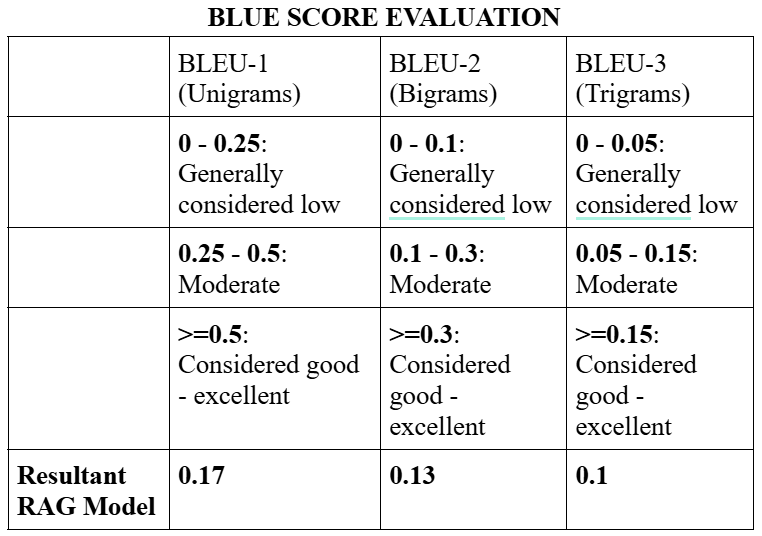

In [ ]:
!pip install rouge


In [ ]:
from rouge import Rouge

def evaluate_rouge_batch(model_outputs, expected_outputs):
    rouge = Rouge()

    rouge_scores = {
        'rouge-1': {'f': 0.0},
        'rouge-2': {'f': 0.0},
        'rouge-l': {'f': 0.0}
    }

    for model_output, expected_output in zip(model_outputs, expected_outputs):
        model_output = [model_output]
        expected_output = [expected_output]
        scores = rouge.get_scores(model_output, expected_output)

        for key in rouge_scores:
            rouge_scores[key]['f'] += scores[0][key]['f']

    num_samples = len(model_outputs)
    for key in rouge_scores:
        rouge_scores[key]['f'] /= num_samples
    for key in rouge_scores:
      rouge_scores[key]=round(rouge_scores[key]['f'],2)

    return rouge_scores

In [ ]:
ROUGE_SCORE=evaluate_rouge_batch(new_df["BOT_ANS"],new_df["Answer"])

In [ ]:
ROUGE_SCORE

{'rouge-1': 0.31, 'rouge-2': 0.16, 'rouge-l': 0.29}

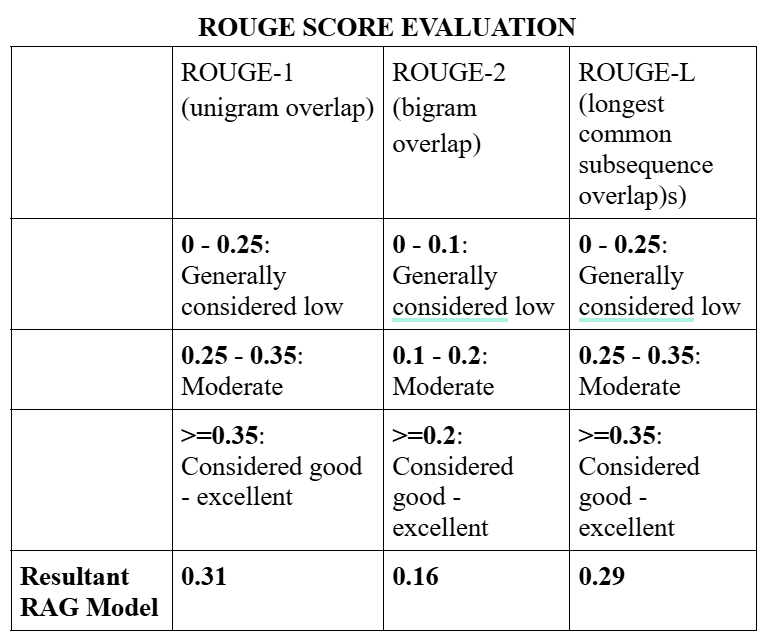